Problem:

Analyze S&P 500 Index Price Data using statistical tests and forecast future returns using the ARIMA model.

Answer the following using your results:

1. According to the Augmented Dickey-Fuller Test, are the returns stationary ? Answer : YES based on the result of the p-value 6.694626e-30 and Confidence level of more than 95%.
2. Assuming that we only choose ARIMA models with p, d, q from 0 to 5, what is the optimal ARIMA order? Answer: Based on parameter combinations for Seasonal ARIMA : p,d,q = 0,0,2
   
3. Using the given dataset, what is tomorrow’s expected return?
   Answer: As of 1997-Dec-05, the predicted stock price is 14.698277.


### STEP 1. DATA PRE-PROCESSING

In [2]:
#Load Libraries
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
import itertools
from datetime import date
import random

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import gc
import warnings
warnings.filterwarnings('ignore')


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Fetching the data

df = pd.read_csv('C:/Users/user/Desktop/Prices.csv')

# convert from string to date type
df['TickerDate'] = pd.to_datetime(df['Ticker'])
df = df.set_index('TickerDate')

df.head()


,Ticker,SPY
TickerDate,,
1997-12-01,12/1/1997,68.10944
1997-12-02,12/2/1997,67.69718
1997-12-03,12/3/1997,67.89246
1997-12-04,12/4/1997,67.82737
1997-12-05,12/5/1997,68.69528


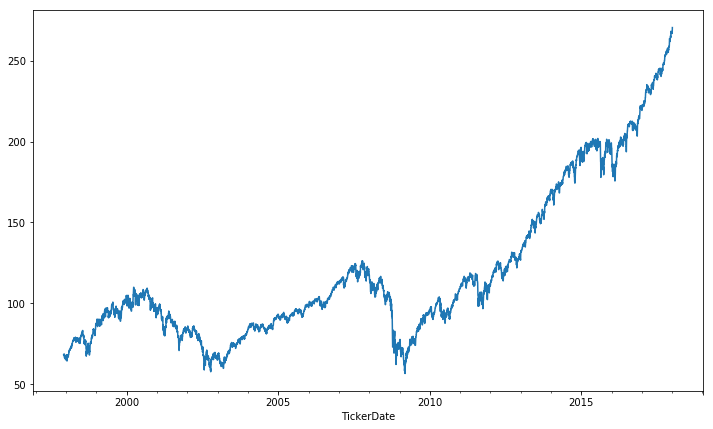

In [4]:
# Plotting the data
df['SPY'].plot(figsize=(12, 7))  

### STEP 2. Augmented Dickey-Fuller test
to determine the stationarity of dataset 

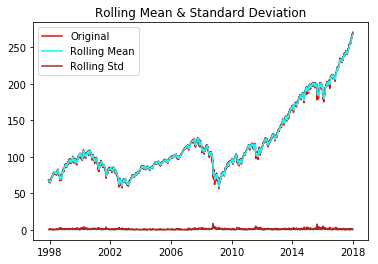

Results of Dickey-Fuller Test:
Test Statistic                    2.134563
p-value                           0.998824
#Lags Used                       11.000000
Number of Observations Used    7327.000000
Critical Value (1%)              -3.431243
Critical Value (5%)              -2.861935
Critical Value (10%)             -2.566980
dtype: float64


In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='red',label='Original')
    mean = plt.plot(rolmean, color='aqua', label='Rolling Mean')
    std = plt.plot(rolstd, color='brown', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    Dickey_Fuller_test(timeseries)
    
def Dickey_Fuller_test(timeseries):
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
test_stationarity(df.SPY)

Comments: The p-value of 0.998 indicates random walk (non-stationarity) so null hypothesis cannot be rejected. 
Recommendation: The exponential graph should be transformed to logarithmic or near linear curve.

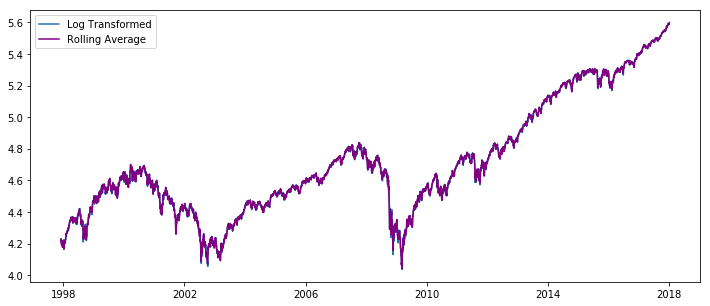

In [6]:
# Linear regression and rolling average to change to a positive upwards trend. 

ts_df_log = np.log(df.SPY)

window = 2
shift_by_days = -2
Rolling_average = ts_df_log.rolling(window = window, center= False).mean()
ts_df_log_rolling_temp = Rolling_average.shift(shift_by_days).dropna()
plt.figure(figsize=(12,5))
plt.plot(ts_df_log, label = 'Log Transformed')
plt.plot(ts_df_log_rolling_temp, color = 'purple', label = 'Rolling Average')
plt.legend(loc = 'best')
plt.show()

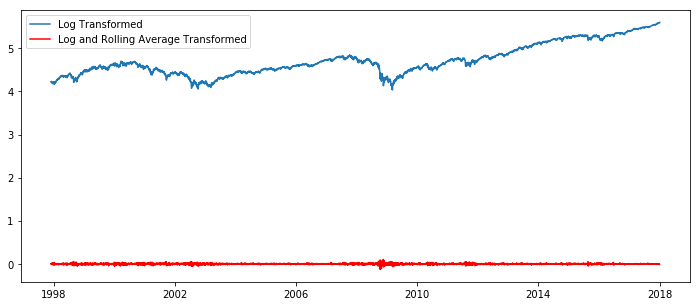

Results of Dickey-Fuller Test:
Test Statistic                -1.717604e+01
p-value                        6.694626e-30
#Lags Used                     2.500000e+01
Number of Observations Used    7.311000e+03
Critical Value (1%)           -3.431245e+00
Critical Value (5%)           -2.861935e+00
Critical Value (10%)          -2.566980e+00
dtype: float64


In [7]:
ts_df_log_rolling = (ts_df_log - ts_df_log_rolling_temp).dropna()
plt.figure(figsize=(12,5))
plt.plot(ts_df_log, label = 'Log Transformed')
plt.plot(ts_df_log_rolling, color = 'red', label = 'Log and Rolling Average Transformed')
plt.legend(loc = 'best')
plt.show()
Dickey_Fuller_test(ts_df_log_rolling)

### Results: p-value is less than alpha of 0.05. 
#### Test Statistic is significantly below the Critical Value (1%) indicating stationarity. 

### STEP 3. Building the ARIMA model
1. After achieving stationarity, the next step is to build an ARIMA model involving three terms --> p,q,d: p = # of AR term using PACF, d = # of differences, q = # of MA term using ACF.
2. AIC (Akaike Information Criterion) computed through SARIMAX grid search    fit the data to it

In [8]:
# ACF and PACF plots
lag = 20
lag_pacf = pacf(ts_df_log_rolling, nlags=lag, method='ols')
lag_acf = acf(ts_df_log_rolling, nlags=lag)

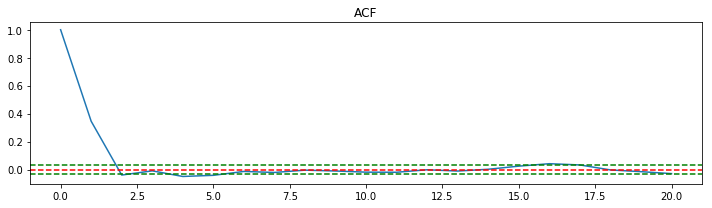

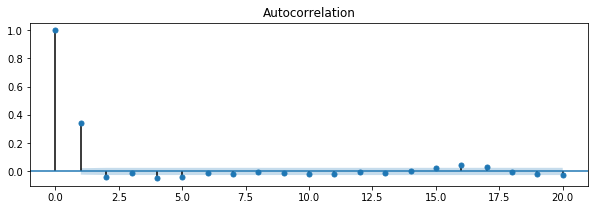

In [10]:
# Plot ACF
plt.figure(figsize=(10,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='red')
plt.axhline(y=-3.00/np.sqrt(len(ts_df_log_rolling)),linestyle='--',color='green')
plt.axhline(y=3.00/np.sqrt(len(ts_df_log_rolling)),linestyle='--',color='green')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plot_acf(ts_df_log_rolling, ax=plt.gca(),lags=lag)
plt.show()

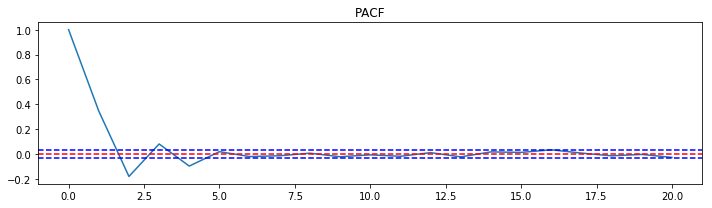

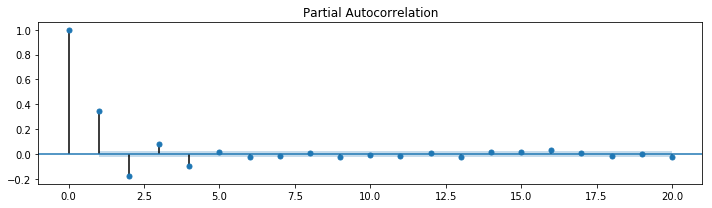

In [11]:
# Plot PACF
plt.figure(figsize=(10,3))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='red')
plt.axhline(y=-2.75/np.sqrt(len(ts_df_log_rolling)),linestyle='--',color='blue')
plt.axhline(y=2.75/np.sqrt(len(ts_df_log_rolling)),linestyle='--',color='blue')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plot_pacf(ts_df_log_rolling, ax=plt.gca(), lags=lag)
plt.tight_layout()
plt.show()

In [13]:
# split into training and test sets
y_train = df[:1997-12-1]# generate all different combinations of seasonal p, d and q triplets
y_test = df[2017-1-1:]

In [14]:
# Define the p, d and q parameters to take any value between 0 and 5
p = d = q = range(0, 5)

In [17]:
# Generate all different combinations of p, d and q 
pdq = list(itertools.product(p, d, q))

In [18]:
# Generate all different combinations of seasonal p, d and q 

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)
SARIMAX: (0, 0, 2) x (0, 0, 4, 12)


In [19]:
p=0

In [20]:
d=0

In [21]:
q=2

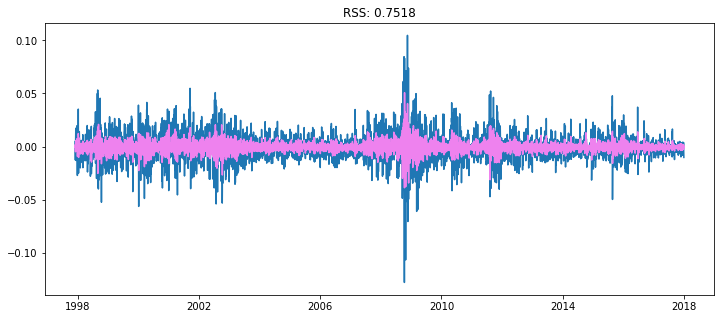

In [22]:
# AR
model = ARIMA(ts_df_log_rolling, order=(p, d, 2))  
results_AR = model.fit(disp=-1)
plt.figure(figsize=(12,5))
plt.plot(ts_df_log_rolling)
plt.plot(results_AR.fittedvalues, color='violet')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_df_log_rolling).dropna()**2))
plt.show()

In [23]:
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    SPY   No. Observations:                 7337
Model:                     ARMA(0, 2)   Log Likelihood               23288.034
Method:                       css-mle   S.D. of innovations              0.010
Date:                Mon, 23 Jul 2018   AIC                         -46568.067
Time:                        17:50:27   BIC                         -46540.464
Sample:                    12-01-1997   HQIC                        -46558.578
                         - 01-01-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -1.727      0.084      -0.001     3.8e-05
ma.L1.SPY      0.4336      0.012     37.277      0.000       0.411       0.456
ma.L2.SPY     -0.0538      0.012     -4.668      0.000      -0.076      -0.031
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.8719           +0.0000j            1.8719            0.5000
MA.2            9.9356           +0.0000j            9.9356            0.0000
-----------------------------------------------------------------------------
"""

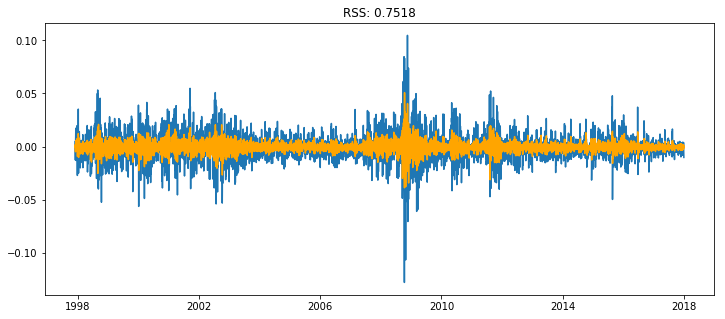

In [24]:
# MA
model = ARIMA(ts_df_log_rolling, order=(0, d, q))  
results_MA = model.fit(disp=-1) 
plt.figure(figsize=(12,5))
plt.plot(ts_df_log_rolling)
plt.plot(results_MA.fittedvalues, color='orange')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_df_log_rolling).dropna()**2))
plt.show()

In [25]:
results_MA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    SPY   No. Observations:                 7337
Model:                     ARMA(0, 2)   Log Likelihood               23288.034
Method:                       css-mle   S.D. of innovations              0.010
Date:                Mon, 23 Jul 2018   AIC                         -46568.067
Time:                        17:50:48   BIC                         -46540.464
Sample:                    12-01-1997   HQIC                        -46558.578
                         - 01-01-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -1.727      0.084      -0.001     3.8e-05
ma.L1.SPY      0.4336      0.012     37.277      0.000       0.411       0.456
ma.L2.SPY     -0.0538      0.012     -4.668      0.000      -0.076      -0.031
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.8719           +0.0000j            1.8719            0.5000
MA.2            9.9356           +0.0000j            9.9356            0.0000
-----------------------------------------------------------------------------
"""

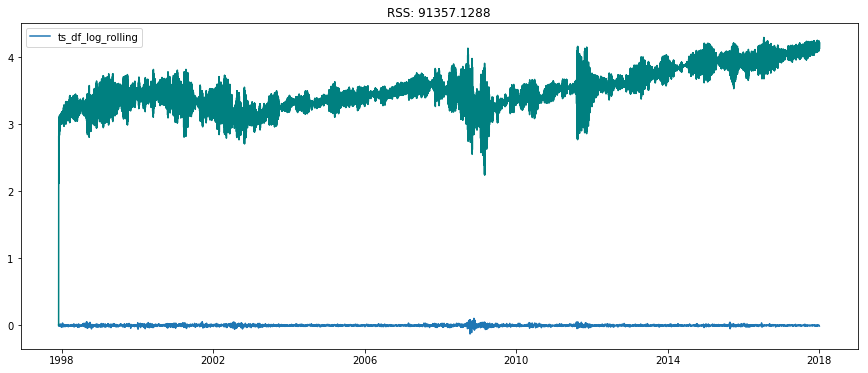

In [26]:
# ARIMA
model = ARIMA(ts_df_log, order=(p, d, q))  
results_ARIMA = model.fit(disp=-1,trend='nc')
plt.figure(figsize=(15,6))
plt.plot(ts_df_log_rolling, label='ts_df_log_rolling')
plt.plot(results_ARIMA.fittedvalues, color='teal')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_df_log_rolling).dropna()**2))
plt.legend(loc='best')
plt.show()

### FORECAST

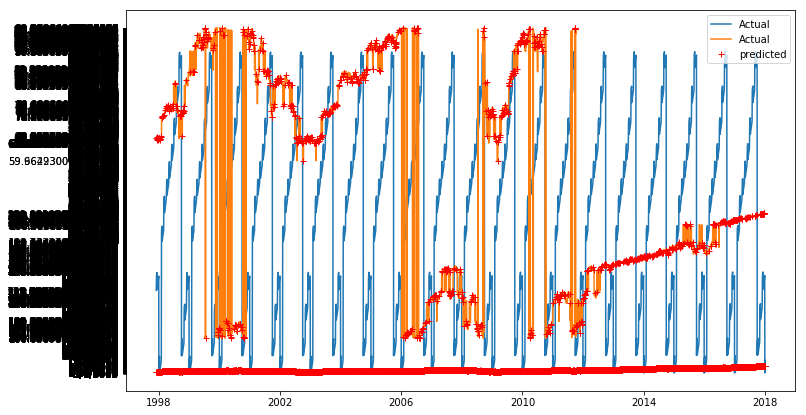

In [27]:
# Actual vs Predicted
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_df_log, index=ts_df_log.index)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

plt.figure(figsize=(12,7))
plt.plot(df, label='Actual')
plt.plot(predictions_ARIMA, 'r+', label='predicted')
plt.legend(loc='best')
plt.show()

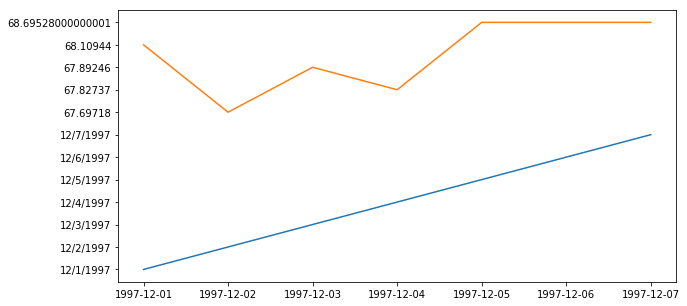

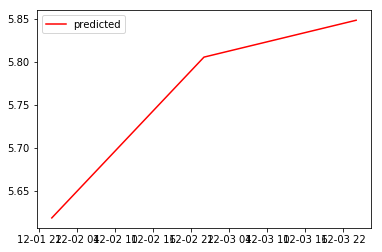

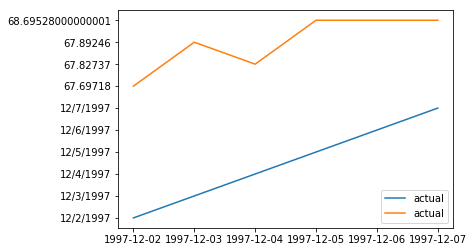

In [28]:
# 7-day forecast
start = 1
end = 7
forecast = results_ARIMA.predict(start=start, end=end)
f = (forecast + forecast.shift(-1))
f = f.shift(-3).dropna()
forecast = f

plt.figure(figsize=(10,5))
plt.plot(df[:end], label='original data')
plt.show()
plt.plot(forecast, color='red', label='predicted')
plt.legend(loc='best')
plt.show()
plt.plot(df[start:end], label='actual')
plt.legend(loc='best')
plt.show()

In [30]:
predictions_ARIMA_log = pd.Series(ts_df_log.ix[0], index=ts_df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

TickerDate
1997-12-01     4.221116
1997-12-02     7.050027
1997-12-03     9.168000
1997-12-04    12.150680
1997-12-05    14.698277
dtype: float64

Overall, the ARIMA model resulted a conservative but continuously upward trend in stock prices forecasts. 